# Model

## Libraries

In [109]:
import pathlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from PIL import Image

import chess

from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [110]:
tf.__version__

'2.10.0'

In [111]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Constants

In [112]:
DATA_DIR = pathlib.Path.cwd().parent / "data" / "deepconvchess-dataset" / "dataset"

## Create TensorFlow Dataset

### Crop Each Image To 64 Partitions

In [113]:
# Dataset
X = []
y = []

for file in DATA_DIR.iterdir():
    if file.is_file() and file.name.endswith(".jpeg"):
        print("Processing %s" % file.name)

        fen = file.name.split(".")[0]
        fen = fen.replace("_", "/")
        board = chess.Board(fen)
        
        # Open image of Chess board
        img = Image.open(DATA_DIR / file.name)
        IMG_WIDTH, IMG_HEIGHT = img.size

        # Crop each image into 64 sections, one for each tile on the board
        for i in range(8):
            for j in range(8):
                crop_x = j * IMG_WIDTH // 8
                crop_y = i * IMG_HEIGHT // 8
                img_crop = img.crop((crop_x, crop_y, crop_x + IMG_WIDTH // 8, crop_y + IMG_HEIGHT // 8))

                piece = board.piece_at(((7 - i) * 8) + j)
                if piece is not None:
                    piece = piece.symbol()
                else:
                    piece = '_'

                X.append(np.array(img_crop))
                y.append(piece)

Processing 1N2r3_2q1ppkp_1p1p1np1_p1nP4_2P2P2_1P4P1_P2Q2BP_3RR1K1 b - - 0 21.jpeg
Processing 1q2r3_4ppkp_1p1p1np1_p1nP4_2P2P2_1P4P1_P2Q2BP_3RR1K1 w - - 0 22.jpeg
Processing 1q2r3_4ppkp_1p1p1np1_p1nP4_2PQ1P2_1P4P1_P5BP_3RR1K1 b - - 1 22.jpeg
Processing 1r1q1rk1_1ppb1pbp_p1np1np1_8_2PNP3_2N1BP2_PP1QB1PP_R4RK1 w - - 6 12.jpeg
Processing 1r1Q2k1_5ppp_2q1p3_1p6_2p2P2_P3P3_1Q4PP_1R4K1 b - - 0 27.jpeg
Processing 1r1qr3_1b1nppkp_pp1p2p1_2n5_2PNP3_1PN3P1_P2Q1PBP_3RR1K1 w - - 2 17.jpeg
Processing 1r1qr3_1b1nppkp_pp1p2p1_2n5_2PNPP2_1PN3P1_P2Q2BP_3RR1K1 b - - 0 17.jpeg
Processing 1r1qr3_1b2ppkp_pp1p1np1_2n5_2PNP3_1PN3P1_P2Q1PBP_3RR1K1 b - - 1 16.jpeg
Processing 1r1qr3_1b2ppkp_pp1p1np1_2n5_2PNP3_1PN3P1_P2Q1PBP_R3R1K1 w - - 0 16.jpeg
Processing 1r1qr3_pb2ppkp_1p1p1np1_2n5_2PNP3_1PN3P1_P2Q1PBP_R3R1K1 b - - 0 15.jpeg
Processing 1r1qr3_pb2ppkp_1p1p1np1_2n5_2PNP3_2N3P1_PP1Q1PBP_R3R1K1 w - - 3 15.jpeg
Processing 1r2r3_1bqnppkp_pp1p2p1_2n5_2PNPP2_1PN3P1_P2Q2BP_3RR1K1 w - - 1 18.jpeg
Processing 1r2r3_1bqnp

In [114]:
len(X)

30208

In [115]:
X = np.array(X)
y = np.array(y)

### Display Example Cropped Board

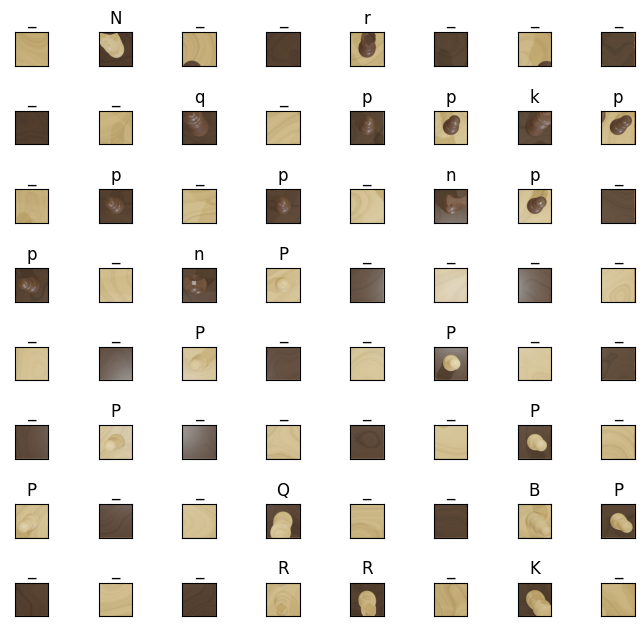

In [116]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=1.5)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

## Encode y labels

In [117]:
from sklearn.preprocessing import LabelEncoder

# Define the labels
labels = ['_', 'p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K']

label_encoder = LabelEncoder()
label_encoder.fit(labels)
y = label_encoder.transform(y)

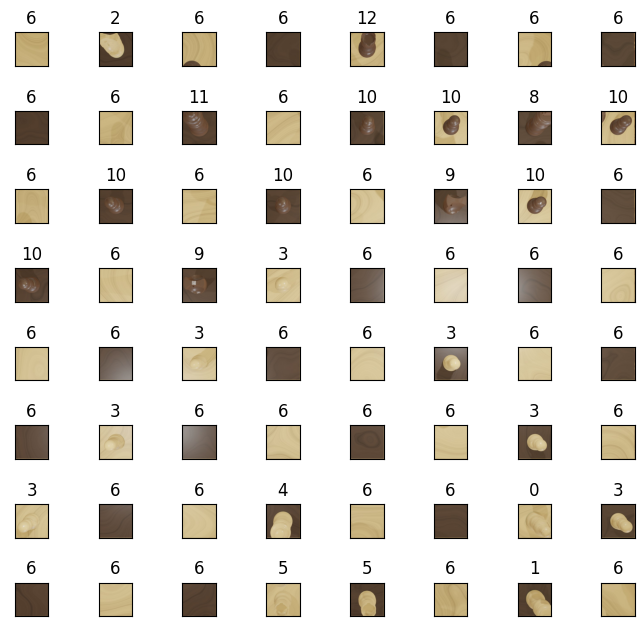

In [118]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=1.5)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

## Test and Train Split

In [119]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the shapes of the train and test split
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (24166, 160, 160, 3)
y_train shape: (24166,)
X_test shape: (6042, 160, 160, 3)
y_test shape: (6042,)


# Model

## ResNet50

In [122]:
NUM_CLASSES = len(['_', 'p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K'])

resnet_model = ResNet50(input_shape=(160, 160, 3), include_top=False)
resnet_model.trainable = False

### Add Output Layer for Chess Pieces

In [123]:
model = Sequential([
    resnet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output')
], name="resnet50")

model.summary()

Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 output (Dense)              (None, 13)                665613    
                                                                 
Total params: 24,253,325
Trainable params: 665,613
Non-trainable params: 23,587,712
_________________________________________________________________


### Compile and Build Model

In [124]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [125]:
model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
756/756 [==============================] - 30s 37ms/step - loss: 0.3163 - accuracy: 0.9856 - val_loss: 0.1403 - val_accuracy: 0.9927
Epoch 2/2
756/756 [==============================] - 27s 35ms/step - loss: 0.0805 - accuracy: 0.9973 - val_loss: 0.0605 - val_accuracy: 0.9977


Text(0.5, 1.0, '3')

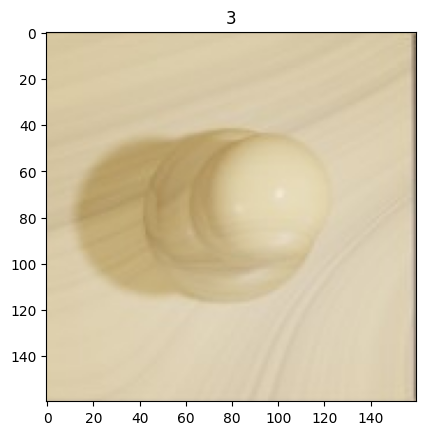

In [126]:
plt.imshow(X_test[0])
plt.title(y_test[0])

### Predictions

In [127]:
for i in range(0, 8):
    image = np.expand_dims(X_test[i], axis=0)

    prediction = model.predict(image)
    prediction = label_encoder.inverse_transform(np.argmax(prediction, axis=1))

    print("True Label: %s, Predicted Label: %s\n" % (label_encoder.inverse_transform([y_test[i]]), prediction))

1/1 [==============================] - 1s 592ms/step
True Label: ['P'], Predicted Label: ['P']

1/1 [==============================] - 0s 19ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 22ms/step
True Label: ['R'], Predicted Label: ['R']

1/1 [==============================] - 0s 22ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 21ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 22ms/step
True Label: ['r'], Predicted Label: ['r']

1/1 [==============================] - 0s 22ms/step
True Label: ['P'], Predicted Label: ['P']

1/1 [==============================] - 0s 23ms/step
True Label: ['_'], Predicted Label: ['_']

